In [1]:
# Importing required libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import openslide

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
BASE_FOLDER = "/kaggle/input/prostate-cancer-grade-assessment/"
!ls {BASE_FOLDER}

sample_submission.csv  test.csv  train.csv  train_images  train_label_masks


In [3]:
mask_dir = f'{BASE_FOLDER}/train_label_masks'

In [4]:
train = pd.read_csv("/Users/johnharshith/Downloads"+BASE_FOLDER+"train.csv")
test = pd.read_csv("/Users/johnharshith/Downloads"+BASE_FOLDER+"test.csv")
sub = pd.read_csv("/Users/johnharshith/Downloads"+BASE_FOLDER+"sample_submission.csv")

In [5]:
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [7]:
train['gleason_score'] = train['gleason_score'].apply(lambda x: "0+0" if x=="negative" else x)

In [8]:
temp = train.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Purples')

,isup_grade,image_id
0,0,2892
1,1,2666
2,2,1342
4,4,1249
3,3,1242
5,5,1224


In [10]:
fig = px.bar(temp, x='isup_grade', y='image_id',hover_data=['image_id', 'isup_grade'], 
            color='image_id',labels={'pop':'population of Canada'}, height=400)
fig.show()

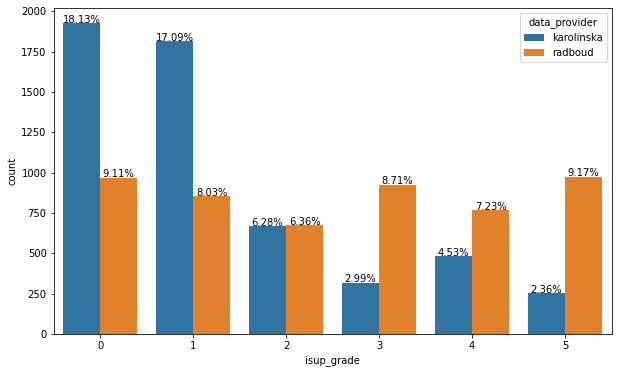

In [11]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height +3,'{:1.2f}%'.format(100*height/10616),ha="center")

In [12]:
temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Reds')

,gleason_score,image_id
0,0+0,2892
1,3+3,2666
2,3+4,1342
4,4+3,1242
5,4+4,1126
6,4+5,849
8,5+4,248
9,5+5,127
3,3+5,80
7,5+3,43


In [14]:
fig = px.bar(temp, x='gleason_score', y='image_id',hover_data=['image_id', 'gleason_score'], 
            color='image_id',labels={'pop':'population of Canada'}, height=400)
fig.show()

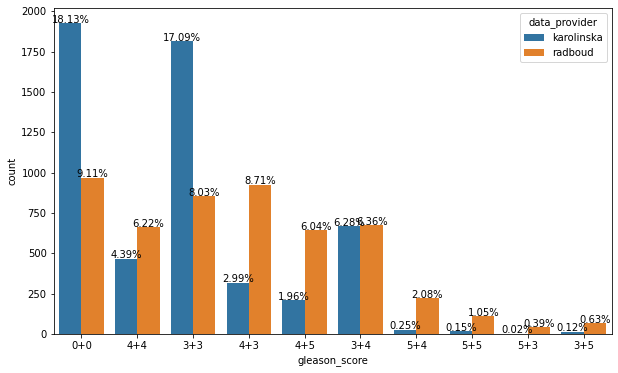

In [15]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="gleason_score", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}%'.format(100*height/10616),ha="center")

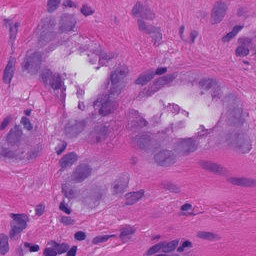

In [16]:
example = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '005e66f06bce9c2e49142536caf2f6ee.tiff'))
# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
patch = example.read_region((17800,19500), 0, (256, 256))
display(patch)
example.close()

In [17]:
train = train.set_index('image_id')
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [18]:
def get_values(image,max_size=(600,400)):
    slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", f'{image}.tiff'))
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    f,ax =  plt.subplots(2 ,figsize=(6,16))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    patch = slide.read_region((1780,1950), 0, (256, 256)) 
    ax[0].imshow(patch) 
    ax[0].set_title('Zoomed Image')
    ax[1].imshow(slide.get_thumbnail(size=max_size))
    ax[1].set_title('Full Image')
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}\n\n")
    print(f"ISUP grade: {train.loc[image, 'isup_grade']}")
    print(f"Gleason score: {train.loc[image, 'gleason_score']}")

File id: OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/07a7ef0ba3bb0d6564a73f4f3e1c2293.tiff')
Dimensions: (24900, 29228)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.00457121779945)
Dimensions of levels: ((24900, 29228), (6225, 7307), (1556, 1826))


ISUP grade: 4
Gleason score: 4+4


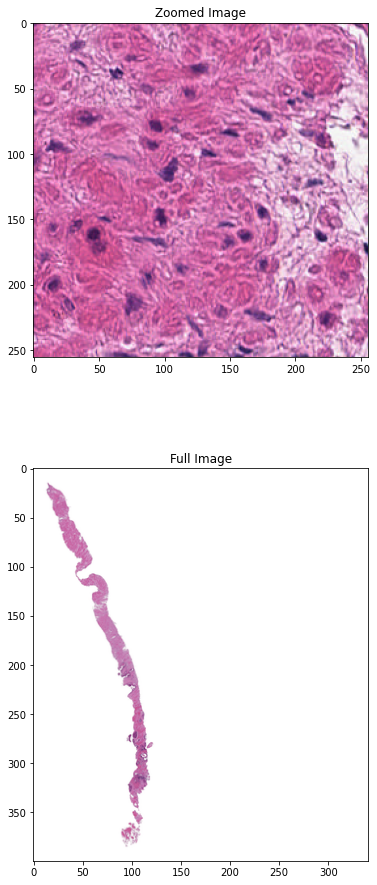

In [19]:
get_values('07a7ef0ba3bb0d6564a73f4f3e1c2293')

In [20]:
def display_images(images):
    '''
    This function takes in input a list of images. It then iterates through the image making openslide objects, 
    on which different functions for getting out information can be called later
    '''
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, image in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", f'{image}.tiff'))
        #Here we compute the "pixel spacing": the physical size of a pixel in the image,
        spacing = 1/(float(slide.properties['tiff.XResolution']) / 10000)
        patch = slide.read_region((1780,1950), 0, (256, 256)) 
        ax[i//3, i%3].imshow(patch) 
        slide.close()       
        ax[i//3, i%3].axis('off')
        image_id = image
        data_provider = train.loc[image, 'data_provider']
        isup_grade = train.loc[image, 'isup_grade']
        gleason_score = train.loc[image, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
    plt.show()

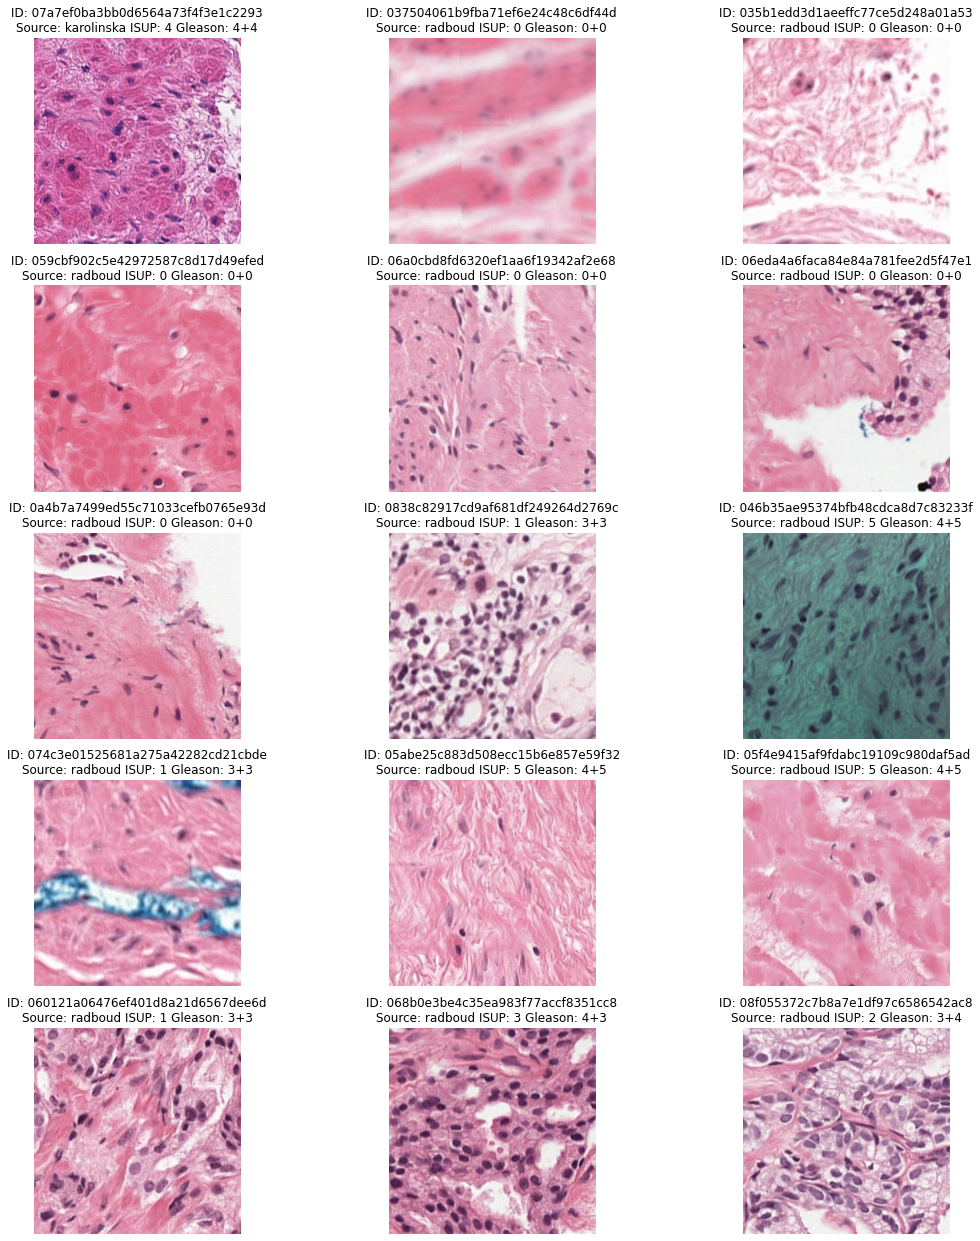

In [21]:
images = [
'07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]
display_images(images)

In [22]:
import pandas as pd
import numpy as np
data=pd.read_csv('/Users/johnharshith/Downloads/prostate-cancer/Prostate_Cancer.csv')
data.head()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [24]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 8.6+ KB


In [25]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
data['diagnosis_result']=enc.fit_transform(data['diagnosis_result'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    int64  
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 8.6 KB


In [26]:
data.describe()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,0.620000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,29.011492,0.487832,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,1.000000,0.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,25.750000,0.000000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,50.500000,1.000000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,75.250000,1.000000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,100.000000,1.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


In [27]:
for column in data.columns:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min()) 
data.head()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,0.000000,1.0,0.8750,0.0625,0.825000,0.448687,1.000000,0.781759,0.633136,0.590909
1,0.010101,0.0,0.0000,0.1250,0.675000,0.670644,1.000000,0.133550,0.272189,0.090909
2,0.020202,1.0,0.7500,1.0000,0.650000,0.597255,0.753425,0.397394,0.426036,0.159091
3,0.030303,1.0,0.3125,0.3125,0.216667,0.109785,0.000000,0.801303,0.739645,1.000000
4,0.040404,1.0,0.0000,0.5000,0.691667,0.653341,0.972603,0.309446,0.272189,0.136364


In [28]:
data.isnull().sum()

id                   0
diagnosis_result     0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
symmetry             0
fractal_dimension    0
dtype: int64

In [29]:
data=data.drop(['id'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis_result   100 non-null    float64
 1   radius             100 non-null    float64
 2   texture            100 non-null    float64
 3   perimeter          100 non-null    float64
 4   area               100 non-null    float64
 5   smoothness         100 non-null    float64
 6   compactness        100 non-null    float64
 7   symmetry           100 non-null    float64
 8   fractal_dimension  100 non-null    float64
dtypes: float64(9)
memory usage: 7.8 KB


In [30]:
data['diagnosis_result'].value_counts()

1.0    62
0.0    38
Name: diagnosis_result, dtype: int64

In [31]:
cls_0=data[data['diagnosis_result']==0]
cls_1=data[data['diagnosis_result']==1]

In [32]:
df_class_1_over = cls_1.sample(250, replace=True)
df_class_0_over = cls_0.sample(250, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1_over], axis=0)
df_test_over.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 92 to 35
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis_result   500 non-null    float64
 1   radius             500 non-null    float64
 2   texture            500 non-null    float64
 3   perimeter          500 non-null    float64
 4   area               500 non-null    float64
 5   smoothness         500 non-null    float64
 6   compactness        500 non-null    float64
 7   symmetry           500 non-null    float64
 8   fractal_dimension  500 non-null    float64
dtypes: float64(9)
memory usage: 39.1 KB


In [33]:
y1=df_test_over['diagnosis_result']
df_test_over=df_test_over.drop(['diagnosis_result'],axis=1)
X1=df_test_over

In [34]:
from sklearn.model_selection import train_test_split
X1_s_train,X1_s_test ,y1_s_train, y1_s_test = train_test_split(X1,y1,test_size=0.25,random_state=0,shuffle = True,stratify = y1)
print('training data shape is :{}.'.format(X1_s_train.shape))
print('training label shape is :{}.'.format(y1_s_train.shape))
print('testing data shape is :{}.'.format(X1_s_test.shape))
print('testing label shape is :{}.'.format(y1_s_test.shape))

training data shape is :(375, 8).
training label shape is :(375,).
testing data shape is :(125, 8).
testing label shape is :(125,).


In [35]:
from sklearn.svm import SVC
svc_s_model = SVC(kernel='poly',gamma=8)
svc_s_model.fit(X1_s_train, y1_s_train)

SVC(gamma=8, kernel='poly')

In [36]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(X1_s_train,y1_s_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions= svc_s_model.predict(X1_s_train)
percentage=svc_s_model.score(X1_s_train,y1_s_train)
res=confusion_matrix(y1_s_train,predictions)
print("Training confusion matrix")
print(res)
predictions= svc_s_model.predict(X1_s_test)
percentage=svc_s_model.score(X1_s_test,y1_s_test)
res=confusion_matrix(y1_s_test,predictions)
print("validation confusion matrix")
print(res)
print(classification_report(y1_s_test, predictions))
print('training accuracy = '+str(svc_s_model.score(X1_s_train, y1_s_train)*100))
print('testing accuracy = '+str(svc_s_model.score(X1_s_test, y1_s_test)*100))

Training confusion matrix
[[184   3]
 [  2 186]]
validation confusion matrix
[[62  1]
 [ 2 60]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98        63
         1.0       0.98      0.97      0.98        62

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125

training accuracy = 98.66666666666667
testing accuracy = 97.6


In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions= xgb.predict(X1_s_train)
percentage=xgb.score(X1_s_train,y1_s_train)
res=confusion_matrix(y1_s_train,predictions)
print("Training confusion matrix")
print(res)
predictions= xgb.predict(X1_s_test)
percentage=xgb.score(X1_s_test,y1_s_test)
res=confusion_matrix(y1_s_test,predictions)
print("validation confusion matrix")
print(res)
print(classification_report(y1_s_test, predictions))
print('training accuracy = '+str(xgb.score(X1_s_train, y1_s_train)*100))
print('testing accuracy = '+str(xgb.score(X1_s_test, y1_s_test)*100))

Training confusion matrix
[[187   0]
 [  0 188]]
validation confusion matrix
[[63  0]
 [ 0 62]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        63
         1.0       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

training accuracy = 100.0
testing accuracy = 100.0
